#### __07. 앙상블 학습과 랜덤 포레스트__

__7.1 투표 기반 분류기__

큰 수의 법칙에 의해 각 분류기가 약한 학습기일지라도 충분히 많고 다양하다면 앙상블은 강한 학습기가 될 수 있다. <br>
단, 이런 가정은 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 가능하다.

In [5]:
import sklearn
import numpy as np
np.random.seed(42)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting="hard"
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC())])

In [12]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [13]:
# 간접투표
'''
모든 분류기의 클래스의 확률을 예측할 수 있으면(predict_proba() 메서드가 있으면) 개별 분류기의 예측을
평균 내어 확률이 가장 높은 클래스를 예측할 수 있다. 이를 간접 투표(soft voting)라고 한다.
SVC는 probability 매개변수를 True로 지정해야 한다.
'''
svm_clf = SVC(probability=True)
voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting="soft"
)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


__7.2 배깅과 페이스팅__

- 배깅(bagging = bootstrap aggregating): 훈련 세트에서 중복을 허용하여 샘플링하는 방식 <br>
- 페이스팅(pasting): 중복을 허용하지 않고 샘플링하는 방식

In [15]:
# 배깅
# bootstrap=False로 하면 페이스팅
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [18]:
# oob(out-of-bag) 샘플을 이용한 평가
# 배깅을 사용 시 어떤 것은 전혀 선택되지 않을 수 있는데 이를 oob라고 하고, 이 샘플들을 이용하여 평가하는 방법
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_  # 테스트 세트에서 약 90.1%의 정확도를 얻음

0.8986666666666666

In [19]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [23]:
# 각 샘플이 음/양 클래스에 속할 확률을 나타냄
bag_clf.oob_decision_function_

array([[0.44382022, 0.55617978],
       [0.33510638, 0.66489362],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06077348, 0.93922652],
       [0.36548223, 0.63451777],
       [0.04624277, 0.95375723],
       [0.98802395, 0.01197605],
       [0.98      , 0.02      ],
       [0.70689655, 0.29310345],
       [0.        , 1.        ],
       [0.79166667, 0.20833333],
       [0.84408602, 0.15591398],
       [0.96428571, 0.03571429],
       [0.06315789, 0.93684211],
       [0.        , 1.        ],
       [0.97560976, 0.02439024],
       [0.93820225, 0.06179775],
       [0.99473684, 0.00526316],
       [0.00529101, 0.99470899],
       [0.37195122, 0.62804878],
       [0.9039548 , 0.0960452 ],
       [1.        , 0.        ],
       [0.9494382 , 0.0505618 ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.63492063, 0.36507937],
       [0.

__7.3 랜덤 패치와 랜덤 서브스페이스__ <br>
<br>
배깅은 샘플 뿐만 아니라 특성 샘플링도 지원한다. 이는 이미지등 고차원 데이터를 다룰 때 유용하다. <br>
훈련 특성과 샘플을 모두 샘플링하는 것을 __랜덤 패치 방식__(random patches method)라고 하고, <br>
훈련 샘플을 모두 사용하고 특성은 샘플링하는 것을 __랜덤 서브스페이스 방식__(random subspace method)라고 한다. <br>

__7.4 랜덤 포레스트__ <br>


In [25]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [26]:
# BaggingClassifier을 사용하여 RandomForestClassfier과 유사하게 만든 것
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16), n_estimators=500)

In [27]:
# 특성 중요도
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09963481781076726
sepal width (cm) 0.02498422243738783
petal length (cm) 0.44027412044883085
petal width (cm) 0.43510683930301414


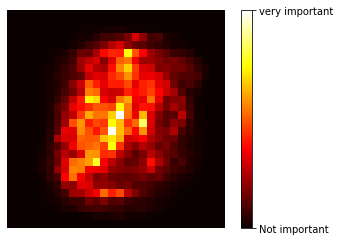

In [29]:
# MNIST 이미지 특성 중요도
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(["Not important", "very important"])
plt.show()

__7.5 부스팅__<br>

약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법을 말한다. <br>
앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것이다. <br>
부스팅 방법으로는 에이다부스트(AdaBoost, adaptive boosting)와 그레이디언트 부스팅(gradient boosting)이 있다.

In [30]:
'''
에이다부스트는 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 방법으로 새로운 예측기가 <br>
학습하기 어려운 샘플에 점점 더 맞춰지게 된다.
'''
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [33]:
# 그레이디언트 부스팅
'''
에이다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가한다.
하지만 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차(residual error)에 새로운 예측기를 학습시킨다.
'''

# DecisionTreeRegressor를 잡음이 섞인 2차 곡선 형태의 훈련 세트에 학습
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

# 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor를 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

# 같은 방법으로 세번째 회귀 모델 훈련
y3 = y2- tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

# 세 개의 트리를 포함하는 앙상블 모델
# 모든 트리의 예측을 더하면 새로운 샘플에 대한 예측이 된다.
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [35]:
# 그레이디언트 부스티드 회귀 트리(Gradient boosted regression tree, GBRT)
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)
y_pred = gbrt.predict(X_new)
y_pred


array([0.75026781])

In [37]:
# 최적의 수를 찾는 방법
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=118)

In [38]:
# 조기종료 구현
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [41]:
# XGBoost

import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

# 자동 조기 종료와 같은 기능도 제공
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.19678
[1]	validation_0-rmse:0.14325
[2]	validation_0-rmse:0.10835
[3]	validation_0-rmse:0.08482
[4]	validation_0-rmse:0.07044
[5]	validation_0-rmse:0.06255
[6]	validation_0-rmse:0.05927
[7]	validation_0-rmse:0.05698
[8]	validation_0-rmse:0.05519
[9]	validation_0-rmse:0.05513
[10]	validation_0-rmse:0.05474
[11]	validation_0-rmse:0.05463
[12]	validation_0-rmse:0.05427
[13]	validation_0-rmse:0.05376
[14]	validation_0-rmse:0.05377
[15]	validation_0-rmse:0.05363
[16]	validation_0-rmse:0.05358
[17]	validation_0-rmse:0.05387
